In [125]:
import pandas as pd 
import seaborn as sns

In [126]:
metadata = pd.read_csv("Metadata.csv")
alphas = pd.read_csv("alpha_diversity_asv_metrics1.csv")

In [127]:
df = pd.read_csv("../../../Linux/cleaned_asv_df.csv")

In [128]:
if 'Row_Sum' in df.columns:
    df = df.drop(columns=['Row_Sum'])

#figure out appropriate sampling depth for Rarefaction
reads = df.iloc[:, 1:-14]

df['Row_Sum'] = reads.iloc[:,:].sum(axis=1)

#figure out exact number of breaking point
depths = df['Row_Sum'][df['Row_Sum'] > 20000]
rarefaction_depth = depths.sort_values().iloc[0]

# Filtering out samples with total reads less than the rarefaction depth
filtered_df = df[df['Row_Sum'] >= rarefaction_depth].copy()

In [129]:
filtered_metadata = metadata.loc[filtered_df.index].reset_index(drop=True)
alphas = alphas.drop(columns="Group")
# 1. Merge the DataFrames based on the index
merged_df = filtered_metadata.join(alphas)
outlier_condition = merged_df['func_stat_badl_total'] > 2000
merged_df.loc[outlier_condition, 'func_stat_badl_total'] = merged_df['func_stat_badl_total'].median()


In [130]:
grouping_vars = [
    'phy_perf_sppbs_total_score_consolidated',
    'cog_mmse_totalscore',
    'func_stat_badl_total',
    'func_stat_iadl_score'
]

# Calculate descriptive statistics using describe()
description_df = merged_df[grouping_vars].describe().transpose()

# Calculate the number of individuals with the median value for each variable
median_counts = merged_df[grouping_vars].apply(lambda x: (x == x.median()).sum())

# Add the count of individuals with the median value as a new column
description_df['median_count'] = median_counts

# Rename the index for clarity (optional)
description_df.index.name = 'Grouping_Variable'

# Reset index to turn the index into a column (optional)
description_df = description_df.reset_index()

# Display the resulting DataFrame
description_df



,Grouping_Variable,count,mean,std,min,25%,50%,75%,max,median_count
0,phy_perf_sppbs_total_score_consolidated,303.0,5.363036,2.810851,0.0,3.0,6.0,8.0,12.0,40
1,cog_mmse_totalscore,303.0,22.504950,4.486825,8.0,20.0,23.0,26.0,30.0,27
2,func_stat_badl_total,303.0,18.861386,2.450962,4.0,19.0,20.0,20.0,20.0,202
3,func_stat_iadl_score,303.0,12.782178,3.528326,1.0,11.0,14.0,16.0,16.0,30


count    303.000000
mean      18.861386
std        2.450962
min        4.000000
25%       19.000000
50%       20.000000
75%       20.000000
max       20.000000
Name: func_stat_badl_total, dtype: float64

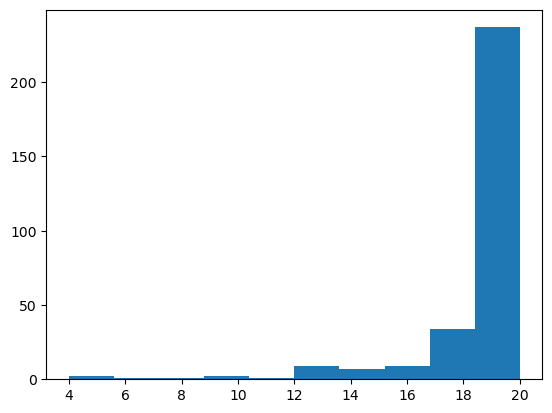

In [131]:
plt.hist(merged_df['func_stat_badl_total'])
merged_df['func_stat_badl_total'].describe()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import pandas as pd
import numpy as np
from itertools import combinations
from matplotlib.patches import Patch

# Assuming 'merged_df' is your DataFrame. Replace with your actual DataFrame variable if different.
# For example:
# merged_df = pd.read_csv('your_data.csv')

# 1. Define the grouping variables and alpha diversity metrics
grouping_vars = [
    'phy_perf_sppbs_total_score_consolidated',
    'cog_mmse_totalscore',
    'func_stat_badl_total',
    'func_stat_iadl_score'
]

metrics = ['Simpson', 'Shannon', 'Pielou_Evenness', 'OTU_Richness']

# 2. Define custom labels for axes
custom_axis_labels = {
    'Simpson': 'Simpson Diversity Index',
    'Shannon': 'Shannon Diversity Index',
    'Pielou_Evenness': "Pielou's Evenness",
    'OTU_Richness': 'ASV Richness',
    'Epigenetic_deviation': 'Epigenetic Deviation (Years)',
    'phy_perf_sppbs_total_score_consolidated': 'Phylogenetic Performance Score',
    'cog_mmse_totalscore': 'Cognitive MMSE Total Score',
    'func_stat_badl_total': 'Functional BADL Total',
    'func_stat_iadl_score': 'Instrumental Activities of Daily Living Score'
}

# 3. Define manual customization for x-axis titles and labels
custom_x_axis_titles = {
    'phy_perf_sppbs_total_score_consolidated_grouped': 'SPPB Scores',
    'cog_mmse_totalscore_grouped': 'MMSE Scores',
    'func_stat_badl_total_grouped': 'BADL Scores',
    'func_stat_iadl_score_grouped': 'IADL Scores'
}

custom_x_labels = {
    'phy_perf_sppbs_total_score_consolidated_grouped': ['Q1', 'Q2', 'Q3', 'Q4'],
    'cog_mmse_totalscore_grouped': ['Q1', 'Q2', 'Q3', 'Q4'],
    'func_stat_badl_total_grouped': ['Group 1', 'Group 2'],
    'func_stat_iadl_score_grouped': ['Q1', 'Q2', 'Q3', 'Q4']
}

# 4. Define the binning function with fallback and custom handling
def create_bins_with_fallback(df, col):
    """
    Attempt to create bins in the order of:
      1) Quartiles (4 bins: Q1, Q2, Q3, Q4)
      2) Tertiles (3 bins: T1, T2, T3)
      3) Median split (2 bins: M1, M2)

    Special handling for 'func_stat_badl_total':
      - Bins: 0 to 19 (inclusive) as 'Group 1', above 19 as 'Group 2'

    Returns:
        (pd.Series of category labels, list_of_labels, list_of_bin_edges) if successful,
        (None, None, None) if not.
    """
    # Custom binning for 'func_stat_badl_total'
    if col == 'func_stat_badl_total':
        try:
            # Define bins: 0 to 19 inclusive, and above 19
            bins = [-np.inf, 19, np.inf]
            labels = ['Group 1', 'Group 2']
            cat_series = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)

            # Check if both bins have at least one sample
            if cat_series.isnull().sum() == 0 and cat_series.nunique() == 2:
                return cat_series, labels, bins
            else:
                print(f"Custom binning for '{col}' did not result in two distinct groups.")
                return None, None, None
        except Exception as e:
            print(f"Error during custom binning for '{col}': {e}")
            return None, None, None

    # Automatic binning for other variables
    def _attempt_qcut(q, labels):
        try:
            # duplicates='drop' will collapse bins if edges overlap
            # so we check if the resulting category has the same number of unique bins
            cat_series, bins = pd.qcut(df[col], q=q, labels=labels, duplicates='drop', retbins=True)
            if cat_series.nunique() == q:
                return cat_series, labels, bins
            return None, None, None
        except Exception:
            return None, None, None

    # 1) Quartiles
    cat_series, labels_, bins = _attempt_qcut(q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    if cat_series is not None:
        return cat_series, labels_, bins

    # 2) Tertiles
    cat_series, labels_, bins = _attempt_qcut(q=3, labels=['T1', 'T2', 'T3'])
    if cat_series is not None:
        return cat_series, labels_, bins

    # 3) Median split
    cat_series, labels_, bins = _attempt_qcut(q=2, labels=['M1', 'M2'])
    if cat_series is not None:
        return cat_series, labels_, bins

    # If all failed
    print(f"Unable to create bins for '{col}' using quartiles, tertiles, or median split.")
    return None, None, None

# 5. Define the plotting function with custom legend and significance stars
def plot_violin_quartiles(ax, metric, df, group_col, group_labels=None,
                         axis_labels=None, group_type=None, bins=None,
                         x_axis_title=None, x_labels_manual=None, add_labels=False, add_legend=False):
    """
    Plots a violin+box+swarm plot for 'metric' across categories in 'group_col' on a given Axes.
    Only draws significance lines (Mann-Whitney U) if p < 0.05, and marks them
    with stars based on significance levels.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to plot on.
        metric (str): The metric to plot.
        df (pd.DataFrame): The DataFrame containing the data.
        group_col (str): The column name for grouping.
        group_labels (list, optional): Custom group labels (e.g., ['Q1', 'Q2', 'Q3', 'Q4']).
        axis_labels (dict, optional): Custom axis labels mapping.
        group_type (str, optional): Type of grouping ('Quartiles', 'Tertiles', 'Median Split', 'Groups', etc.).
        bins (list, optional): Bin edges for generating bin ranges.
        x_axis_title (str, optional): Manual title for the x-axis.
        x_labels_manual (list, optional): Manual labels for the x-axis groups.
        add_labels (bool, optional): Whether to add x-axis labels and title.
        add_legend (bool, optional): Whether to add the legend.
    """
    if group_labels is None:
        group_labels = sorted(df[group_col].dropna().unique().tolist())

    # Sort group labels according to their categorical order
    sorted_groups = [g for g in group_labels if g in df[group_col].unique()]

    # If fewer than 2 groups, we cannot do pairwise tests
    if len(sorted_groups) < 2:
        print(f"Not enough distinct bins to plot '{group_col}'.")
        return

    # Define color palette
    palette = sns.color_palette("Set3", n_colors=len(sorted_groups))
    color_dict = dict(zip(sorted_groups, palette))

    # Calculate group sizes
    group_counts = df[group_col].value_counts().sort_index()

    # Generate bin range labels with mathematical signs
    bin_ranges = {}
    if bins is not None and len(bins) == len(sorted_groups) + 1:
        for i, grp in enumerate(sorted_groups):
            lower = bins[i]
            upper = bins[i + 1]
            # Handle -inf and inf
            if lower == -np.inf:
                bin_ranges[grp] = f"≤ {int(upper)}"
            elif upper == np.inf:
                bin_ranges[grp] = f"> {int(lower)}"
            else:
                bin_ranges[grp] = f"> {int(lower)} and ≤ {int(upper)}"
    else:
        # If bins are not provided or don't match, fallback to group labels
        for grp in sorted_groups:
            bin_ranges[grp] = grp  # Fallback to group label

    # Create x_labels with (n=XX) appended
    if x_labels_manual is not None:
        x_labels = [f"{label} (n={group_counts[grp]})" for grp, label in zip(sorted_groups, x_labels_manual)]
    else:
        x_labels = [f"{grp} (n={group_counts[grp]})" for grp in sorted_groups]

    # Create the violin plot
    sns.violinplot(
        x=group_col, y=metric, data=df,
        order=sorted_groups, inner=None, palette=color_dict, cut=0, ax=ax
    )

    # Add box plot inside the violin
    sns.boxplot(
        x=group_col, y=metric, data=df,
        order=sorted_groups, showcaps=False, boxprops={'facecolor': 'None'},
        showfliers=False, whiskerprops={'linewidth': 0}, ax=ax
    )

    # Add swarm of points
    sns.swarmplot(
        x=group_col, y=metric, data=df,
        order=sorted_groups, color="k", alpha=0.6, ax=ax
    )

    # Compute pairwise Mann-Whitney U tests
    pairs = list(combinations(sorted_groups, 2))
    p_values = {}
    for pair in pairs:
        group1 = df[df[group_col] == pair[0]][metric].dropna()
        group2 = df[df[group_col] == pair[1]][metric].dropna()
        if len(group1) > 0 and len(group2) > 0:
            _, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
            p_values[pair] = p_val
        else:
            p_values[pair] = 1.0  # Non-significant if no data

    # Set up y-label
    ylabel = axis_labels.get(metric, custom_axis_labels.get(metric, f'{metric} Diversity'))
    ax.set_ylabel(ylabel, fontsize=24)

    # Set up x-axis title and labels only if add_labels is True
    if add_labels:
        if x_axis_title is not None:
            xlabel = x_axis_title
        else:
            xlabel = f"{custom_axis_labels.get(group_col, group_col.replace('_', ' ').title())} {group_type}"
        ax.set_xlabel(xlabel, fontsize=24)
        ax.set_xticklabels(x_labels, fontsize=20)
    else:
        # Hide x-axis labels for subplots above the last one
        ax.set_xlabel('')
        ax.set_xticklabels([])
    
    ax.tick_params(axis='y', labelsize=20)

    # Adjust y-axis limits to provide space for any annotation
    max_val = df[metric].max()
    min_val = df[metric].min()
    y_range = max_val - min_val
    ax.set_ylim(min_val - 0.1 * y_range, max_val + 0.3 * y_range)

    # Annotate each pairwise comparison ONLY if p < 0.05
    annotation_offset = 0.05 * y_range
    line_height_increment = 0.03 * y_range
    sig_count = 0  # to stack lines upward

    for pair in pairs:
        p_val = p_values[pair]
        if p_val < 0.05:
            x1 = sorted_groups.index(pair[0])
            x2 = sorted_groups.index(pair[1])
            y_pos = max_val + annotation_offset + sig_count * line_height_increment

            # Draw the connecting line
            ax.plot([x1, x1, x2, x2],
                    [y_pos, y_pos + line_height_increment / 2,
                     y_pos + line_height_increment / 2, y_pos],
                    lw=1.5, c='k')

            # Determine the number of stars based on p-value
            if p_val < 0.001:
                stars = '***'
            elif p_val < 0.01:
                stars = '**'
            else:
                stars = '*'

            # Place the stars above the line
            ax.text((x1 + x2) / 2, y_pos + line_height_increment / 2,
                    stars, ha='center', va='bottom', color='k', fontsize=20)
            sig_count += 1

    # Create custom legend with actual bin ranges
    legend_elements = []
    for grp in sorted_groups:
        label = bin_ranges.get(grp, grp)
        legend_elements.append(Patch(facecolor=color_dict[grp], edgecolor='k', label=label))

    # Set legend title based on grouping type
    if group_type in ['Quartiles', 'Tertiles', 'Median Split']:
        legend_title = group_type
    else:
        legend_title = 'Groups'

    # Specifically for 'Epigenetic_deviation_grouped', set legend title to "Quartiles (Years)"
    if group_var == 'Epigenetic_deviation':
        legend_title = 'Quartiles (Years)'

    # Add the legend only if add_legend is True
    if add_legend:
        # Create the legend with larger title font
        ax.legend(handles=legend_elements, title=legend_title, bbox_to_anchor=(1.05, 1),
                  loc='upper left', fontsize=20, title_fontsize=24)

# 6. Define the binning function with fallback and custom handling (already defined as create_bins_with_fallback)

# 7. Main loop: handle custom binning for 'func_stat_badl_total' and automatic binning for others
for group_var in grouping_vars:
    group_label_col = f"{group_var}_grouped"

    if group_var == 'func_stat_badl_total':
        # Custom binning for 'func_stat_badl_total'
        # Define bins: 0 to 19 inclusive as 'Group 1', above 19 as 'Group 2'
        try:
            merged_df[group_label_col] = pd.cut(
                merged_df[group_var],
                bins=[-np.inf, 19, np.inf],
                labels=['Group 1', 'Group 2'],
                include_lowest=True
            )

            # Check if both bins have at least one sample
            if merged_df[group_label_col].isnull().sum() > 0 or merged_df[group_label_col].nunique() < 2:
                print(f"Custom binning for '{group_var}' did not result in two distinct groups. Skipping...")
                continue

            # Ensure the new grouping column is categorical with the desired order
            merged_df[group_label_col] = pd.Categorical(
                merged_df[group_label_col],
                categories=['Group 1', 'Group 2'],
                ordered=True
            )

            # Get the bin edges for 'func_stat_badl_total'
            bins = [-np.inf, 19, np.inf]

            # Define group_type
            group_type = 'Groups'

        except Exception as e:
            print(f"Error during custom binning for '{group_var}': {e}")
            continue
    else:
        # Automatic binning for other variables
        binned_col, bin_labels, bins = create_bins_with_fallback(merged_df, group_var)
        if binned_col is None:
            print(f"Could not create valid bins for '{group_var}'. Skipping...")
            continue

        # Assign to DataFrame
        merged_df[group_label_col] = binned_col
        # Make sure categories are in the correct order
        merged_df[group_label_col] = pd.Categorical(
            merged_df[group_label_col],
            categories=bin_labels,
            ordered=True
        )

        # Determine group_type based on number of bins
        num_bins = len(bin_labels)
        if num_bins == 4:
            group_type = 'Quartiles'
        elif num_bins == 3:
            group_type = 'Tertiles'
        elif num_bins == 2:
            group_type = 'Median Split'
        else:
            group_type = 'Groups'

        # If group_var is 'Epigenetic_deviation', append '(Years)' to group_type
        if group_var == 'Epigenetic_deviation':
            group_type += ' (Years)'

    # Identify the number of metrics
    num_metrics = len(metrics)

    # Create a figure with subplots (vertically stacked)
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(14, 6 * num_metrics), sharex=False)
    
    # If only one metric, axes will not be a list
    if num_metrics == 1:
        axes = [axes]

    # Generate violin plots for each metric
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        print(f"Generating plot for Metric: {metric} | Grouping Variable: {group_var}")
        
        # Define group labels based on the current binning strategy
        if group_var == 'func_stat_badl_total':
            current_group_labels = ['Group 1', 'Group 2']
            x_labels_manual_current = custom_x_labels.get(group_label_col, None)
        else:
            current_group_labels = bin_labels
            x_labels_manual_current = custom_x_labels.get(group_label_col, None)

        # Determine whether to add labels and legend
        # Only add labels and legend to the last subplot
        add_labels = (idx == num_metrics - 1)
        add_legend = (idx == num_metrics - 1)

        # Call the plotting function
        plot_violin_quartiles(
            ax=ax, 
            metric=metric, 
            df=merged_df, 
            group_col=group_label_col, 
            group_labels=current_group_labels,
            axis_labels=custom_axis_labels,
            group_type=group_type,
            bins=bins,  # Pass bin edges to the plotting function
            x_axis_title=custom_x_axis_titles.get(group_label_col, None),
            x_labels_manual=x_labels_manual_current,
            add_labels=add_labels,
            add_legend=add_legend
        )
    
    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Uncomment the following line to save the figures in publication quality
    plt.savefig(f"{group_var}_alpha_diversity_plots.png", format='png', dpi=600, bbox_inches='tight')

    plt.show()
    plt.close()


In [143]:
merged_df.columns

Index(['Sample_ID', 'phy_perf_sppbs_total_score_consolidated',
       'cog_mmse_totalscore', 'func_stat_badl_total', 'func_stat_iadl_score',
       'Age', 'Epigenetic_deviation', 'BMI', 'Group', 'Race_1_0', 'Race_2_0',
       'Race_3_0', 'Race_4.0', 'Sex_1_0', 'Sex_2.0', 'Smoking_0_0',
       'Smoking_1_0', 'Smoking_2.0', 'time_diff_v1_bio', 'time_diff_v4_bio',
       'time_diff_v5_bio', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
       'PC8', 'PC9', 'PC10', 'Shannon', 'Simpson', 'Chao1', 'OTU_Richness',
       'Pielou_Evenness', 'PC5*time_diff', 'PC9*time_diff',
       'Epigenetic_deviation_grouped',
       'phy_perf_sppbs_total_score_consolidated_grouped',
       'cog_mmse_totalscore_grouped', 'func_stat_badl_total_grouped',
       'func_stat_iadl_score_grouped'],
      dtype='object')

In [134]:
merged_df["PC5*time_diff"] = merged_df["PC5"] * merged_df["time_diff_v1_bio"]
merged_df["PC9*time_diff"] = merged_df["PC9"] * merged_df["time_diff_v1_bio"]

In [158]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
import matplotlib.pyplot as plt

# Assuming `merged_df` is already loaded
# Define the alpha diversity metrics and covariates
alpha_diversity_metrics = ['Simpson', 'Shannon', 'Pielou_Evenness', 'OTU_Richness']
covariates = ['time_diff_v1_bio', 'PC5*time_diff', 'PC9*time_diff']

# Drop rows with missing values in relevant columns
relevant_columns = ['func_stat_badl_total_grouped'] + alpha_diversity_metrics + covariates
filtered_df = merged_df.dropna(subset=relevant_columns)

# Initialize a list to store results
results_list = []

# Loop through each alpha diversity metric
for metric in alpha_diversity_metrics:
    # Define the independent variables for each model
    independent_vars = [metric] + covariates
    
    # Extract X and y for binary logistic regression
    X_binary = filtered_df[independent_vars]
    y_binary = filtered_df['func_stat_badl_total_grouped']
    
    # Encode BADL_Group (assume 'Group 1' -> 0 and 'Group 2' -> 1)
    y_binary_encoded = y_binary.map({'Group 1': 0, 'Group 2': 1})
    
    # Add constant to the independent variables
    X_binary = sm.add_constant(X_binary)
    
    # Fit Logistic Regression
    logistic_model = sm.GLM(y_binary_encoded, X_binary, family=Binomial())
    logistic_results = logistic_model.fit()

    print(logistic_results.summary())
    
    # Store the summary as a string in the results list
    results_list.append({
        "Metric": metric,
        "Summary": logistic_results.summary().as_text()
    })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Save results to Excel
results_file_path = 'BADL_GLM_results.xlsx'
results_df.to_excel(results_file_path, index=False)

# Provide the file to the user
results_file_path


                      Generalized Linear Model Regression Results                       
Dep. Variable:     func_stat_badl_total_grouped   No. Observations:                  218
Model:                                      GLM   Df Residuals:                      213
Model Family:                          Binomial   Df Model:                            4
Link Function:                            Logit   Scale:                          1.0000
Method:                                    IRLS   Log-Likelihood:                -137.80
Date:                          Mon, 06 Jan 2025   Deviance:                       275.61
Time:                                  14:29:32   Pearson chi2:                     217.
No. Iterations:                               4   Pseudo R-squ. (CS):            0.02851
Covariance Type:                      nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

'BADL_GLM_results.xlsx'

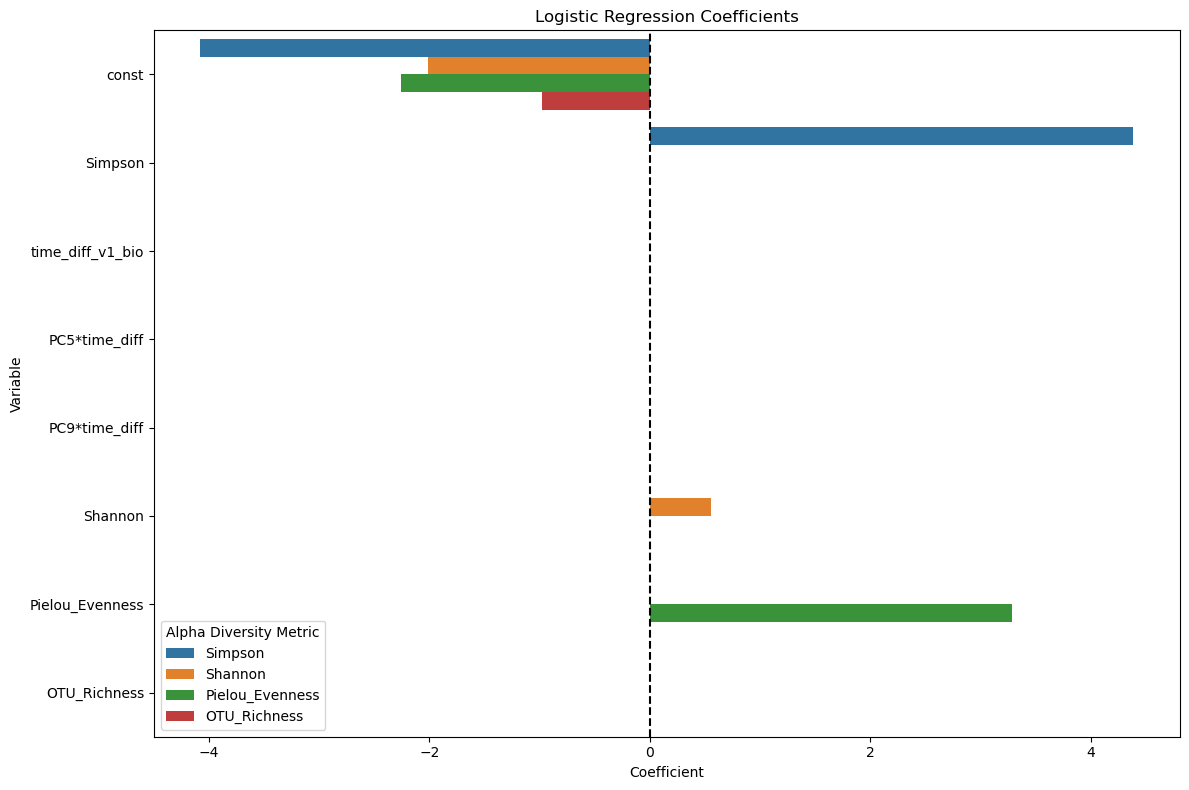

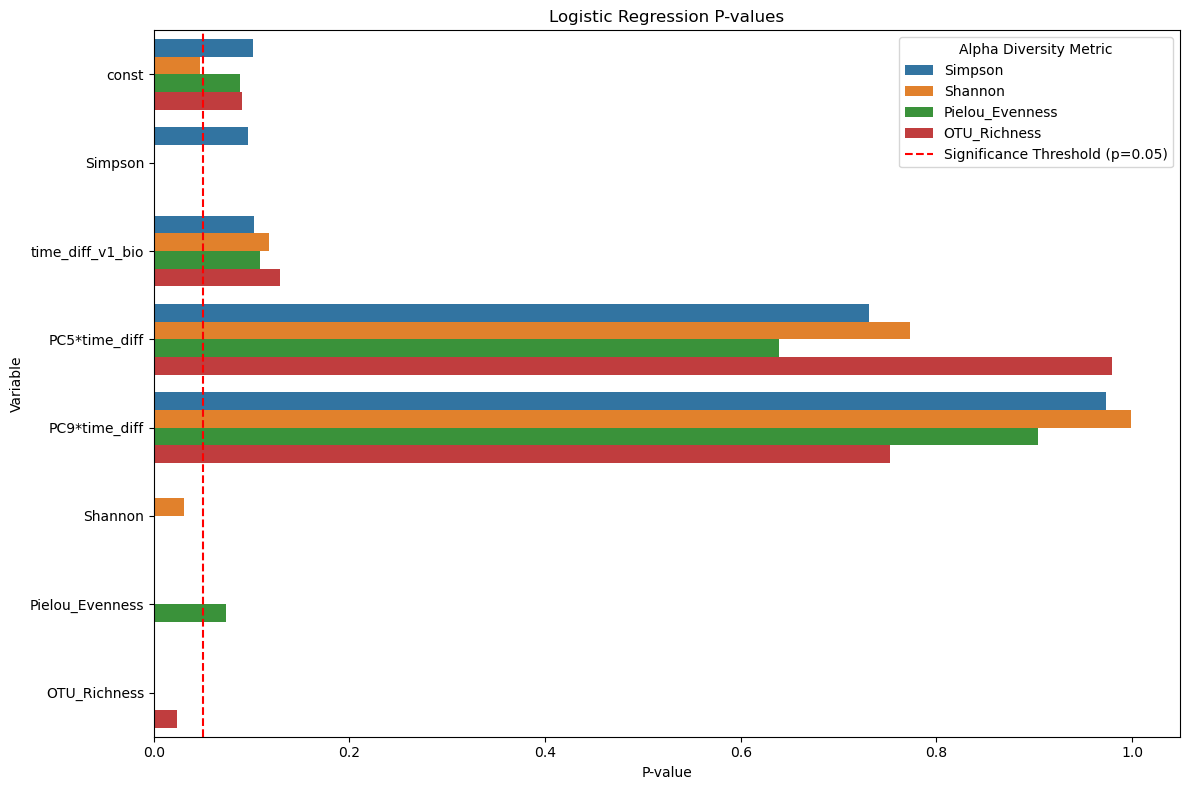

In [161]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from openpyxl import Workbook
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 1. Load and Prepare Data
# ================================
# Assuming `merged_df` is already loaded
# Define the alpha diversity metrics and covariates
alpha_diversity_metrics = ['Simpson', 'Shannon', 'Pielou_Evenness', 'OTU_Richness']
covariates = ['time_diff_v1_bio', 'PC5*time_diff', 'PC9*time_diff']

# Drop rows with missing values in relevant columns
relevant_columns = ['func_stat_badl_total_grouped'] + alpha_diversity_metrics + covariates
filtered_df = merged_df.dropna(subset=relevant_columns)

# ================================
# 2. Fit Logistic Regression for Each Metric and Save Results as Excel
# ================================
# Create a new Excel workbook
workbook = Workbook()

for metric in alpha_diversity_metrics:
    # Define the independent variables for each model
    independent_vars = [metric] + covariates
    
    # Extract X and y for binary logistic regression
    X_binary = filtered_df[independent_vars]
    y_binary = filtered_df['func_stat_badl_total_grouped']
    
    # Encode BADL_Group (assume 'Group 1' -> 0 and 'Group 2' -> 1)
    y_binary_encoded = y_binary.map({'Group 1': 0, 'Group 2': 1})
    
    # Add constant to the independent variables
    X_binary = sm.add_constant(X_binary)
    
    # Fit Logistic Regression
    logistic_model = sm.GLM(y_binary_encoded, X_binary, family=Binomial())
    logistic_results = logistic_model.fit()
    
    # Create a new sheet in the workbook for this metric
    sheet = workbook.create_sheet(title=metric)
    
    # Write the model summary to the sheet
    summary_text = logistic_results.summary().as_text().splitlines()
    for i, line in enumerate(summary_text):
        sheet.cell(row=i + 1, column=1, value=line)

# Remove the default sheet created by openpyxl
if "Sheet" in workbook.sheetnames:
    workbook.remove(workbook["Sheet"])

# Save the workbook to a file
excel_file_path = 'logistic_regression_results.xlsx'
workbook.save(excel_file_path)

# ================================
# 3. Plot Coefficients and P-values as Bar Plots
# ================================
# Extract coefficients and p-values for plotting
results_data = []

for metric in alpha_diversity_metrics:
    independent_vars = [metric] + covariates
    X_binary = filtered_df[independent_vars]
    y_binary_encoded = filtered_df['func_stat_badl_total_grouped'].map({'Group 1': 0, 'Group 2': 1})
    X_binary = sm.add_constant(X_binary)
    logistic_model = sm.GLM(y_binary_encoded, X_binary, family=Binomial())
    logistic_results = logistic_model.fit()
    summary = logistic_results.summary2().tables[1]
    summary['Metric'] = metric
    summary['Variable'] = summary.index
    results_data.append(summary)

# Combine all results into a single DataFrame
combined_results_df = pd.concat(results_data)

# Plot coefficients
plt.figure(figsize=(12, 8))
sns.barplot(data=combined_results_df, x='Coef.', y='Variable', hue='Metric')
plt.axvline(0, color='black', linestyle='--')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.legend(title='Alpha Diversity Metric')
plt.tight_layout()
#plt.savefig('logistic_regression_coefficients_bar.png', dpi=300)
plt.show()

# Plot p-values
plt.figure(figsize=(12, 8))
sns.barplot(data=combined_results_df, x='P>|z|', y='Variable', hue='Metric')
plt.axvline(0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')
plt.title('Logistic Regression P-values')
plt.xlabel('P-value')
plt.ylabel('Variable')
plt.legend(title='Alpha Diversity Metric')
plt.tight_layout()
#plt.savefig('logistic_regression_pvalues_bar.png', dpi=300)
plt.show()
